In [18]:
import os
os.chdir(os.environ['PROJECT_DIR'])

import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import numpy as np

from pyod.models.copod import COPOD
from pyod.models.abod import ABOD
from pyod.models.lof import LOF
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

import umap.umap_ as umap
from sklearn.decomposition import PCA

In [3]:
DATA_DIR = "data/vectorized/test_dataset"

In [4]:
# load test dataset - known outliers marked
test_dataset = pd.read_csv("data/utils/test_dataset.csv")
tfidf_vectors = np.load(os.path.join(DATA_DIR, "tfidf_vectors.npy"))
bert_vectors = np.load(os.path.join(DATA_DIR, "bert_vectors.npy"))
doc2vec_vectors = np.load(os.path.join(DATA_DIR, "doc2vec_vectors.npy"))

feature_vectors = [tfidf_vectors , doc2vec_vectors, bert_vectors]

### Functions

In [84]:
# [TODO]: Put functions in seperate file

# visualization
def display_outliers(scores):
    subplots_adjust(hspace=0.000)
    n_subplots = len(scores)

    # dynamic amount of plots using 1 column
    for i in range(n_subplots):
        ax = subplot(n_subplots, 1, i+1)
        ax.plot(range(100), scores[i])

# outlier detection methods
def copula_od(X):    
    detector = COPOD()
    scores = detector.decision_function(X)
    return scores

def angle_od(X):
    detector = ABOD().fit(X)
    scores = detector.decision_scores_
    return scores

def ang_cosine_sim_od(X):
    # get pairwise cosine similarities
    cosine_matrix = cosine_similarity(X, X)
    # remove same vectors in calculation
    np.fill_diagonal(cosine_matrix, 0)
    # get the normalized sum of each row
    scores = [sum(row) / len(X) for row in cosine_matrix]

    return scores

# dimensionality reduction methods
def PCA_reduce(X, dimension):
    pca = PCA(n_components=dimension)
    return pca.fit_transform(X)
    
def UMAP_reduce(X, dimension):
    _umap = umap.UMAP(random_state=1,n_components=dimension)
    return _umap.fit_transform(X)

def TSNE_reduce(X, dimension):
    return None
    
# aggregate methods
def reduce_vectors(vectors, reduce_method, dimension):
    vectors = [reduce_method(v, dimension) for v in vectors]
    return vectors

def test_outliers(vectors, od_method):
    all_scores = [od_method(v) for v in vectors]
    display_outliers(all_scores)
    return all_scores

### Analysis

In [6]:
'''
Copula-Based Outlier Detection - https://arxiv.org/pdf/2009.09463.pdf

This method was chosen due to its high efficiency with high dimensional data and no hyperparemeters to tune. The high efficiency of the model is due to the algorithm
treating each feature as independent.
Among the 10 popular detectors in comparison, COPOD ranks first, and scores 1.5% more in ROC-AUC and 2.7% more in Average Precision than the
second best performing detector. 

Analysis:
Due to the outlier detection method already being known for its high success rate with different types of data, the feature extraction method will positvely correlate to
our results. This means that the better the method, the better our results. Since BERT is a large language model (LLM), it is able to extract the features of our data more
affectively.

Since BERT was not trained our documents, we would expect better results if we were to leverage transfer learning - further train a pretrained LLM on our documents.
'''

'\nCopula-Based Outlier Detection - https://arxiv.org/pdf/2009.09463.pdf\n\nThis method was chosen due to its high efficiency with high dimensional data and no hyperparemeters to tune. The high efficiency of the model is due to the algorithm\ntreating each feature as independent.\nAmong the 10 popular detectors in comparison, COPOD ranks first, and scores 1.5% more in ROC-AUC and 2.7% more in Average Precision than the\nsecond best performing detector. \n\nAnalysis:\nDue to the outlier detection method already being known for its high success rate with different types of data, the feature extraction method will positvely correlate to\nour results. This means that the better the method, the better our results. Since BERT is a large language model (LLM), it is able to extract the features of our data more\naffectively.\n\nSince BERT was not trained our documents, we would expect better results if we were to leverage transfer learning - further train a pretrained LLM on our documents.\n'

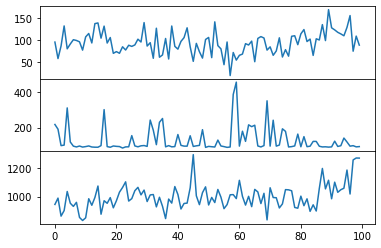

In [7]:
copod_scores = test_outliers(feature_vectors, copula_od)

In [8]:
'''
Angle Based Outlier Detection - https://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD2008.pdf

A lot of outlier detection methods look to find outliers through density and or distance. These methods are highly affected due to the curse of dimensionality, where with n 
number of dimensions you need 10^n points to have a sufficient space. Since we are using text data, that is highly sparse, distance-based approaches do not give us a great 
picture on outliers. We can combat this through the use of angle-based approaches since angles are less affected by dimensions.

Analysis:
From the results, weirdly enough, we can see that TF-IDF works the best in finding our outliers, where the two last documents (our outliers) have the worst decision scores.
'''

'\nAngle Based Outlier Detection - https://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD2008.pdf\n\nA lot of outlier detection methods look to find outliers through density and or distance. These methods are highly affected due to the curse of dimensionality, where with n \nnumber of dimensions you need 10^n points to have a sufficient space. Since we are using text data, that is highly sparse, distance-based approaches do not give us a great \npicture on outliers. We can combat this through the use of angle-based approaches since angles are less affected by dimensions.\n\nAnalysis:\nFrom the results, weirdly enough, we can see that TF-IDF works the best in finding our outliers, where the two last documents (our outliers) have the worst decision scores.\n'

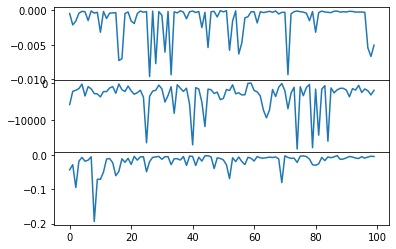

In [9]:
# no dimensionality reduction
apod_scores_no_reduce = test_outliers(feature_vectors, angle_od)

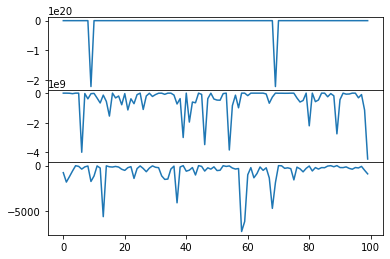

In [10]:
# PCA reduction
pca_vectors = reduce_vectors(feature_vectors, PCA_reduce, dimension=4)
apod_scores_pca = test_outliers(pca_vectors, angle_od)

In [11]:
print(np.argsort(apod_scores_pca[2])[:2])
test_dataset.iloc[59]['text']

[58 59]


'These taro-stuffed hedgehog buns are both adorable and delicious! Enjoy as a quick snack, or serve as an adorable dessert.'

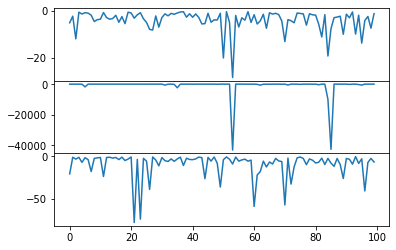

In [12]:
# UMAP reduction
umap_vectors = reduce_vectors(feature_vectors, UMAP_reduce, dimension=4)
apod_scores_umap = test_outliers(umap_vectors, angle_od)

In [13]:
print(np.argsort(apod_scores_umap[2])[:2])
test_dataset.iloc[21]['text']

[21 23]


'This avocado cacao smoothie is full of heart-healthy fats and tastes like dessert! Whip it up for breakfast to fuel you all day long!'

In [82]:
'''
Modified (Normalized) Cosine Similarity

We know that cosine similarity is an affective way of determing if two vectors are similar to each other. Since the calculation is so efficient, we propose a method similar 
to angle-based outlier detection, where we calculate the normalized sum of the cosine similarities between the vector pairs. This way, the vectors with the lowest scores are
the outliers since they were the least similar to other vectors within the feature set.

Results:
We can see that this algorithm performs similarly to COPOD outlier detection where the BERT feature set works to find an outlier that we missed originally within the 
dataset. Better results are actually found in the TF-IDF vectors, which was not seen with the COPOD algorithm. This ends up being one the best methods for determining outliers
in this smaller test dataset.
'''

'\nModified (Normalized) Cosine Similarity\n\nWe know that cosine similarity is an affective way of determing if two vectors are similar to each other. Since the calculation is so efficient, we propose a method similar \nto angle-based outlier detection, where we calculate the normalized sum of the cosine similarities between the vector pairs. This way, the vectors with the lowest scores are\nthe outliers since they were the least similar to other vectors within the feature set.\n'

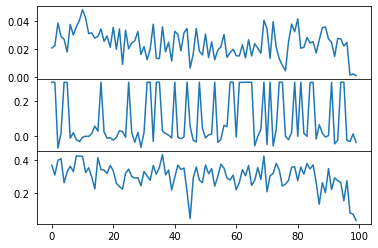

In [81]:
avg_cosine_sim_scores = test_outliers(feature_vectors, ang_cosine_sim_od)

In [90]:
test_dataset.iloc[45]['text'] # outlier found that we didn't originally set as an outlier - found substantially using BERT feature set

'This content is intended solely for users of legal drinking age. Drink responsibly.'

In [15]:
'''
Distance Based Approaches using Dimensionality Reduction

Since text embeddings are typically high dimensional (as mentioned before), the obvious answer is to reduce the dimensionality when leveraging distance-based approaches
To do so, we can leverage different dimensionality reduction / feature extraction techniques -- this will create a low dimensional latent space to perform our 
outlier detection in. Some of these methods include: PCA, UMAP, etc.
'''

'\nDistance Based Approaches using Dimensionality Reduction\n\nSince text embeddings are typically high dimensional (as mentioned before), the obvious answer is to reduce the dimensionality when leveraging distance-based approaches\nTo do so, we can leverage different dimensionality reduction / feature extraction techniques -- this will create a low dimensional latent space to perform our \noutlier detection in. Some of these methods include: PCA, UMAP, etc.\n'

### Overall

In [ ]:
'''
Overall, we can see that the Doc2Vec didn't work as great as the other feature extraction methods. This is most likely due to the fact that we only had 100 documents to train
the model on. If we were to use this on a larger dataset, we would hopefully expect better results. 
'''